In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import *
from torch.utils.data import DataLoader

# <center>Pré-processamento dos dados</center>

In [2]:
train_path = 'Dataset/train'
test_path = 'Dataset/test'

In [3]:
transform_train = transforms.Compose(
    [transforms.Resize(size = (512,512)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
transform_test = transforms.Compose(
    [transforms.Resize(size = (512,512)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
train_dataset = datasets.ImageFolder(train_path, transform = transform_train)
test_dataset = datasets.ImageFolder(test_path, transform = transform_test)

In [6]:
trainloader = DataLoader(train_dataset, batch_size = 30, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 90, shuffle = True)

# <center>Implementação da arquitetura CNN</center>

In [7]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    
    nn.Flatten(),
    
    nn.Linear(256 * 32 * 32, 256),
    nn.ReLU(),

    nn.Linear(256, 128),
    nn.ReLU(),
    
    nn.Linear(128, 64),
    nn.ReLU(),
    
    nn.Linear(64, 3)
)        

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stri

In [9]:
num_epoch = 40
learning_rate = 0.001

In [10]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [11]:
train_losses = []
train_acc = []

for epoch in range(num_epoch):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(trainloader)
    train_losses.append(train_loss)

    _, predicted = torch.max(outputs.data, 1)
    acc = accuracy_score(labels, predicted)
    train_acc.append(acc)

    print(f"Época {epoch + 1}/{num_epoch} - Perda no treinamento: {train_loss:.6f} - Acurácia: {acc:.2f}")

Época 1/40 - Perda no treinamento: 6.842808 - Acurácia: 0.70
Época 2/40 - Perda no treinamento: 0.887786 - Acurácia: 0.80
Época 3/40 - Perda no treinamento: 0.293353 - Acurácia: 0.87
Época 4/40 - Perda no treinamento: 0.182139 - Acurácia: 0.83
Época 5/40 - Perda no treinamento: 0.094222 - Acurácia: 1.00
Época 6/40 - Perda no treinamento: 0.071757 - Acurácia: 1.00
Época 7/40 - Perda no treinamento: 0.028174 - Acurácia: 0.97
Época 8/40 - Perda no treinamento: 0.014973 - Acurácia: 1.00
Época 9/40 - Perda no treinamento: 0.002072 - Acurácia: 1.00
Época 10/40 - Perda no treinamento: 0.001162 - Acurácia: 1.00
Época 11/40 - Perda no treinamento: 0.001193 - Acurácia: 1.00
Época 12/40 - Perda no treinamento: 0.000508 - Acurácia: 1.00
Época 13/40 - Perda no treinamento: 0.000500 - Acurácia: 1.00
Época 14/40 - Perda no treinamento: 0.000627 - Acurácia: 1.00
Época 15/40 - Perda no treinamento: 0.000411 - Acurácia: 1.00
Época 16/40 - Perda no treinamento: 0.000344 - Acurácia: 1.00
Época 17/40 - Per

Text(0.5, 0.98, 'Treinamento')

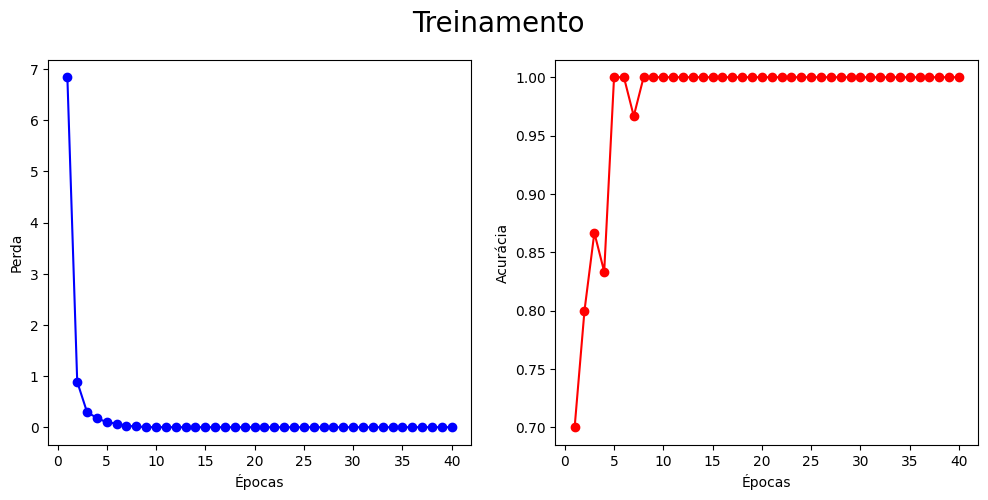

In [12]:
epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento", fontsize = 20)

In [13]:
model.eval()
    
with torch.no_grad():
        
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        acc = accuracy_score(labels, predicted)
        
print(f"Acurácia: {acc:.2f}")

Acurácia: 0.98


# Métricas de avaliação

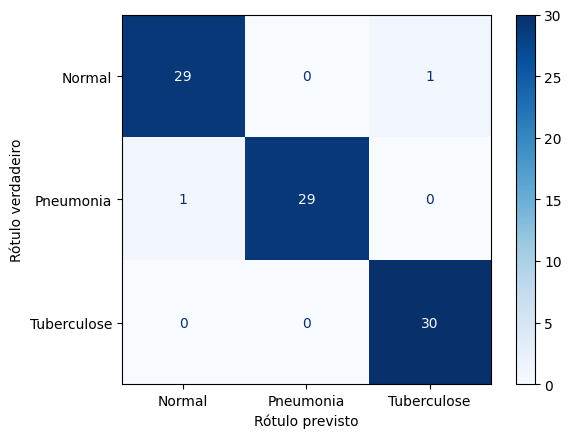

In [14]:
cm = confusion_matrix(labels, predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia', 'Tuberculose'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [15]:
precision = precision_score(labels, predicted, average='weighted')
print(f"Precisão: {precision:.2f}")

Precisão: 0.98


In [16]:
recall = recall_score(labels, predicted, average='weighted')
print(f"Recall: {recall:.2f}")

Recall: 0.98


In [17]:
f1 = f1_score(labels, predicted, average='weighted')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.98
